In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[0].mean(dim=1).cpu().numpy())
    
    return np.vstack(hidden_states)


def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:05<00:00,  3.53it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 232/232 [00:05<00:00, 44.71it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:37<00:00,  2.50it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 243/243 [00:03<00:00, 77.66it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4864 and hidden_dim=256


Training Epochs:   1%|          | 11/2000 [00:05<12:33,  2.64it/s]

Epoch 10/2000, Loss: 0.6743
Test Accuracy at Epoch 10: 63.16%
Test F1-score at Epoch 10: 0.6045
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.63      0.69      0.66       194
non_infringement       0.64      0.58      0.60       186

        accuracy                           0.63       380
       macro avg       0.63      0.63      0.63       380
    weighted avg       0.63      0.63      0.63       380

New best model saved with F1-score 0.6045 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.63      0.69      0.66       194
non_infringement       0.64      0.58      0.60       186

        accuracy                           0.63       380
       macro avg       0.63      0.63      0.63       380
    weighted avg       0.63      0.63      0.63       380



Training Epochs:   1%|          | 20/2000 [00:08<08:58,  3.67it/s]

Epoch 20/2000, Loss: 0.6464
Test Accuracy at Epoch 20: 61.32%
Test F1-score at Epoch 20: 0.6697
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.69      0.43      0.53       194
non_infringement       0.58      0.80      0.67       186

        accuracy                           0.61       380
       macro avg       0.63      0.62      0.60       380
    weighted avg       0.64      0.61      0.60       380

New best model saved with F1-score 0.6697 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.69      0.43      0.53       194
non_infringement       0.58      0.80      0.67       186

        accuracy                           0.61       380
       macro avg       0.63      0.62      0.60       380
    weighted avg       0.64      0.61      0.60       380



Training Epochs:   2%|▏         | 30/2000 [00:10<07:20,  4.47it/s]

Epoch 30/2000, Loss: 0.5913
Test Accuracy at Epoch 30: 61.32%
Test F1-score at Epoch 30: 0.6711
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.70      0.43      0.53       194
non_infringement       0.57      0.81      0.67       186

        accuracy                           0.61       380
       macro avg       0.64      0.62      0.60       380
    weighted avg       0.64      0.61      0.60       380

New best model saved with F1-score 0.6711 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.70      0.43      0.53       194
non_infringement       0.57      0.81      0.67       186

        accuracy                           0.61       380
       macro avg       0.64      0.62      0.60       380
    weighted avg       0.64      0.61      0.60       380



Training Epochs:   2%|▏         | 41/2000 [00:12<04:21,  7.49it/s]

Epoch 40/2000, Loss: 0.5521
Test Accuracy at Epoch 40: 73.68%
Test F1-score at Epoch 40: 0.7512
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

New best model saved with F1-score 0.7512 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:   2%|▎         | 50/2000 [00:15<14:57,  2.17it/s]

Epoch 50/2000, Loss: 0.5209
Test Accuracy at Epoch 50: 66.05%
Test F1-score at Epoch 50: 0.7165
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.79      0.45      0.58       194
non_infringement       0.61      0.88      0.72       186

        accuracy                           0.66       380
       macro avg       0.70      0.66      0.65       380
    weighted avg       0.70      0.66      0.65       380



Training Epochs:   3%|▎         | 59/2000 [00:20<17:45,  1.82it/s]

Epoch 60/2000, Loss: 0.4980
Test Accuracy at Epoch 60: 75.00%
Test F1-score at Epoch 60: 0.7689
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.82      0.65      0.73       194
non_infringement       0.70      0.85      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:   3%|▎         | 60/2000 [00:20<20:04,  1.61it/s]

New best model saved with F1-score 0.7689 at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.82      0.65      0.73       194
non_infringement       0.70      0.85      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:   3%|▎         | 69/2000 [00:25<16:56,  1.90it/s]

Epoch 70/2000, Loss: 0.4525
Test Accuracy at Epoch 70: 77.89%
Test F1-score at Epoch 70: 0.7846
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.81      0.74      0.77       194
non_infringement       0.75      0.82      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:   4%|▎         | 70/2000 [00:26<19:01,  1.69it/s]

New best model saved with F1-score 0.7846 at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.81      0.74      0.77       194
non_infringement       0.75      0.82      0.78       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:   4%|▍         | 80/2000 [00:29<09:07,  3.51it/s]

Epoch 80/2000, Loss: 0.4078
Test Accuracy at Epoch 80: 78.16%
Test F1-score at Epoch 80: 0.7981
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380

New best model saved with F1-score 0.7981 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.86      0.69      0.76       194
non_infringement       0.73      0.88      0.80       186

        accuracy                           0.78       380
       macro avg       0.79      0.78      0.78       380
    weighted avg       0.79      0.78      0.78       380



Training Epochs:   4%|▍         | 90/2000 [00:32<10:24,  3.06it/s]

Epoch 90/2000, Loss: 0.4106
Test Accuracy at Epoch 90: 63.68%
Test F1-score at Epoch 90: 0.7125
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.83      0.37      0.51       194
non_infringement       0.58      0.92      0.71       186

        accuracy                           0.64       380
       macro avg       0.70      0.64      0.61       380
    weighted avg       0.71      0.64      0.61       380



Training Epochs:   5%|▌         | 100/2000 [00:35<09:25,  3.36it/s]

Epoch 100/2000, Loss: 0.3610
Test Accuracy at Epoch 100: 74.74%
Test F1-score at Epoch 100: 0.7808
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.88      0.58      0.70       194
non_infringement       0.68      0.92      0.78       186

        accuracy                           0.75       380
       macro avg       0.78      0.75      0.74       380
    weighted avg       0.78      0.75      0.74       380



Training Epochs:   6%|▌         | 110/2000 [00:40<16:32,  1.90it/s]

Epoch 110/2000, Loss: 0.3599
Test Accuracy at Epoch 110: 79.21%
Test F1-score at Epoch 110: 0.7948
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.82      0.76      0.79       194
non_infringement       0.77      0.82      0.79       186

        accuracy                           0.79       380
       macro avg       0.79      0.79      0.79       380
    weighted avg       0.79      0.79      0.79       380



Training Epochs:   6%|▌         | 120/2000 [00:45<16:07,  1.94it/s]

Epoch 120/2000, Loss: 0.3634
Test Accuracy at Epoch 120: 68.16%
Test F1-score at Epoch 120: 0.7420
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.88      0.44      0.58       194
non_infringement       0.61      0.94      0.74       186

        accuracy                           0.68       380
       macro avg       0.75      0.69      0.66       380
    weighted avg       0.75      0.68      0.66       380



Training Epochs:   6%|▋         | 130/2000 [00:48<08:19,  3.74it/s]

Epoch 130/2000, Loss: 0.3284
Test Accuracy at Epoch 130: 79.47%
Test F1-score at Epoch 130: 0.8040
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.85      0.73      0.78       194
non_infringement       0.75      0.86      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380

New best model saved with F1-score 0.8040 at epoch 130
Best Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.85      0.73      0.78       194
non_infringement       0.75      0.86      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:   7%|▋         | 140/2000 [00:50<05:31,  5.62it/s]

Epoch 140/2000, Loss: 0.3387
Test Accuracy at Epoch 140: 71.58%
Test F1-score at Epoch 140: 0.7600
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.87      0.52      0.65       194
non_infringement       0.65      0.92      0.76       186

        accuracy                           0.72       380
       macro avg       0.76      0.72      0.71       380
    weighted avg       0.76      0.72      0.70       380



Training Epochs:   8%|▊         | 150/2000 [00:51<04:34,  6.74it/s]

Epoch 150/2000, Loss: 0.3101
Test Accuracy at Epoch 150: 71.58%
Test F1-score at Epoch 150: 0.7600
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.87      0.52      0.65       194
non_infringement       0.65      0.92      0.76       186

        accuracy                           0.72       380
       macro avg       0.76      0.72      0.71       380
    weighted avg       0.76      0.72      0.70       380



Training Epochs:   8%|▊         | 160/2000 [00:53<06:31,  4.69it/s]

Epoch 160/2000, Loss: 0.2868
Test Accuracy at Epoch 160: 79.21%
Test F1-score at Epoch 160: 0.8049
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380

New best model saved with F1-score 0.8049 at epoch 160
Best Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.86      0.71      0.78       194
non_infringement       0.74      0.88      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:   9%|▊         | 171/2000 [00:55<04:26,  6.86it/s]

Epoch 170/2000, Loss: 0.5028
Test Accuracy at Epoch 170: 60.79%
Test F1-score at Epoch 170: 0.7107
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.94      0.25      0.39       194
non_infringement       0.56      0.98      0.71       186

        accuracy                           0.61       380
       macro avg       0.75      0.62      0.55       380
    weighted avg       0.75      0.61      0.55       380



Training Epochs:   9%|▉         | 181/2000 [00:56<04:29,  6.76it/s]

Epoch 180/2000, Loss: 0.2804
Test Accuracy at Epoch 180: 66.84%
Test F1-score at Epoch 180: 0.7429
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.95      0.37      0.53       194
non_infringement       0.60      0.98      0.74       186

        accuracy                           0.67       380
       macro avg       0.77      0.67      0.64       380
    weighted avg       0.78      0.67      0.64       380



Training Epochs:  10%|▉         | 191/2000 [00:58<03:45,  8.02it/s]

Epoch 190/2000, Loss: 0.2756
Test Accuracy at Epoch 190: 79.47%
Test F1-score at Epoch 190: 0.8000
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.83      0.75      0.79       194
non_infringement       0.76      0.84      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.80      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  10%|█         | 202/2000 [00:59<03:09,  9.47it/s]

Epoch 200/2000, Loss: 0.2741
Test Accuracy at Epoch 200: 71.84%
Test F1-score at Epoch 200: 0.7679
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.91      0.49      0.64       194
non_infringement       0.64      0.95      0.77       186

        accuracy                           0.72       380
       macro avg       0.78      0.72      0.71       380
    weighted avg       0.78      0.72      0.70       380



Training Epochs:  10%|█         | 210/2000 [01:01<08:41,  3.43it/s]

Epoch 210/2000, Loss: 0.2643
Test Accuracy at Epoch 210: 78.95%
Test F1-score at Epoch 210: 0.8058
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380

New best model saved with F1-score 0.8058 at epoch 210
Best Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.87      0.69      0.77       194
non_infringement       0.73      0.89      0.81       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  11%|█         | 220/2000 [01:05<09:55,  2.99it/s]

Epoch 220/2000, Loss: 0.2547
Test Accuracy at Epoch 220: 79.47%
Test F1-score at Epoch 220: 0.8116
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       194
non_infringement       0.74      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380

New best model saved with F1-score 0.8116 at epoch 220
Best Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.88      0.69      0.77       194
non_infringement       0.74      0.90      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  12%|█▏        | 230/2000 [01:07<10:38,  2.77it/s]

Epoch 230/2000, Loss: 0.2455
Test Accuracy at Epoch 230: 80.53%
Test F1-score at Epoch 230: 0.8255
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.92      0.68      0.78       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380

New best model saved with F1-score 0.8255 at epoch 230
Best Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.92      0.68      0.78       194
non_infringement       0.74      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.81      0.80       380
    weighted avg       0.83      0.81      0.80       380



Training Epochs:  12%|█▏        | 240/2000 [01:11<10:46,  2.72it/s]

Epoch 240/2000, Loss: 0.2390
Test Accuracy at Epoch 240: 79.74%
Test F1-score at Epoch 240: 0.8136
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.88      0.70      0.78       194
non_infringement       0.74      0.90      0.81       186

        accuracy                           0.80       380
       macro avg       0.81      0.80      0.80       380
    weighted avg       0.81      0.80      0.80       380



Training Epochs:  12%|█▎        | 250/2000 [01:13<09:14,  3.16it/s]

Epoch 250/2000, Loss: 0.2639
Test Accuracy at Epoch 250: 70.26%
Test F1-score at Epoch 250: 0.7601
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.93      0.45      0.61       194
non_infringement       0.63      0.96      0.76       186

        accuracy                           0.70       380
       macro avg       0.78      0.71      0.68       380
    weighted avg       0.78      0.70      0.68       380



Training Epochs:  13%|█▎        | 260/2000 [01:16<04:35,  6.32it/s]

Epoch 260/2000, Loss: 0.2308
Test Accuracy at Epoch 260: 81.32%
Test F1-score at Epoch 260: 0.8305
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.79       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380

New best model saved with F1-score 0.8305 at epoch 260
Best Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.79       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  14%|█▎        | 270/2000 [01:21<15:58,  1.80it/s]

Epoch 270/2000, Loss: 0.2257
Test Accuracy at Epoch 270: 81.32%
Test F1-score at Epoch 270: 0.8305
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.92      0.70      0.79       194
non_infringement       0.75      0.94      0.83       186

        accuracy                           0.81       380
       macro avg       0.83      0.82      0.81       380
    weighted avg       0.83      0.81      0.81       380



Training Epochs:  14%|█▍        | 280/2000 [01:23<04:45,  6.03it/s]

Epoch 280/2000, Loss: 0.2207
Test Accuracy at Epoch 280: 72.63%
Test F1-score at Epoch 280: 0.7719
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.71       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  15%|█▍        | 291/2000 [01:25<05:06,  5.57it/s]

Epoch 290/2000, Loss: 0.2594
Test Accuracy at Epoch 290: 77.37%
Test F1-score at Epoch 290: 0.7624
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.76      0.80      0.78       194
non_infringement       0.78      0.74      0.76       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  15%|█▌        | 300/2000 [01:28<09:32,  2.97it/s]

Epoch 300/2000, Loss: 0.2599
Test Accuracy at Epoch 300: 82.37%
Test F1-score at Epoch 300: 0.8354
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.90      0.74      0.81       194
non_infringement       0.77      0.91      0.84       186

        accuracy                           0.82       380
       macro avg       0.83      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380

New best model saved with F1-score 0.8354 at epoch 300
Best Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.90      0.74      0.81       194
non_infringement       0.77      0.91      0.84       186

        accuracy                           0.82       380
       macro avg       0.83      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



Training Epochs:  16%|█▌        | 310/2000 [01:29<04:14,  6.64it/s]

Epoch 310/2000, Loss: 0.2290
Test Accuracy at Epoch 310: 71.32%
Test F1-score at Epoch 310: 0.7656
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.92      0.48      0.63       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.71       380
       macro avg       0.78      0.72      0.70       380
    weighted avg       0.78      0.71      0.70       380



Training Epochs:  16%|█▌        | 320/2000 [01:34<13:01,  2.15it/s]

Epoch 320/2000, Loss: 0.2262
Test Accuracy at Epoch 320: 72.11%
Test F1-score at Epoch 320: 0.7686
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.91      0.51      0.65       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.72       380
       macro avg       0.78      0.73      0.71       380
    weighted avg       0.78      0.72      0.71       380



Training Epochs:  16%|█▋        | 330/2000 [01:36<03:58,  7.01it/s]

Epoch 330/2000, Loss: 0.2168
Test Accuracy at Epoch 330: 72.89%
Test F1-score at Epoch 330: 0.7736
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.72       380
    weighted avg       0.78      0.73      0.72       380



Training Epochs:  17%|█▋        | 341/2000 [01:37<03:36,  7.66it/s]

Epoch 340/2000, Loss: 0.2118
Test Accuracy at Epoch 340: 72.37%
Test F1-score at Epoch 340: 0.7702
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.91      0.51      0.65       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.72       380
       macro avg       0.78      0.73      0.71       380
    weighted avg       0.78      0.72      0.71       380



Training Epochs:  18%|█▊        | 351/2000 [01:38<03:48,  7.22it/s]

Epoch 350/2000, Loss: 0.2065
Test Accuracy at Epoch 350: 72.63%
Test F1-score at Epoch 350: 0.7719
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.71       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  18%|█▊        | 362/2000 [01:40<02:41, 10.11it/s]

Epoch 360/2000, Loss: 0.2023
Test Accuracy at Epoch 360: 72.63%
Test F1-score at Epoch 360: 0.7719
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.71       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  18%|█▊        | 370/2000 [01:40<02:33, 10.64it/s]

Epoch 370/2000, Loss: 0.2169
Test Accuracy at Epoch 370: 72.11%
Test F1-score at Epoch 370: 0.7716
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.64       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  19%|█▉        | 380/2000 [01:42<03:44,  7.23it/s]

Epoch 380/2000, Loss: 0.2435
Test Accuracy at Epoch 380: 71.05%
Test F1-score at Epoch 380: 0.7650
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.93      0.47      0.62       194
non_infringement       0.63      0.96      0.76       186

        accuracy                           0.71       380
       macro avg       0.78      0.72      0.69       380
    weighted avg       0.78      0.71      0.69       380



Training Epochs:  20%|█▉        | 390/2000 [01:44<06:23,  4.20it/s]

Epoch 390/2000, Loss: 0.2045
Test Accuracy at Epoch 390: 72.63%
Test F1-score at Epoch 390: 0.7719
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.71       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  20%|██        | 400/2000 [01:48<12:39,  2.11it/s]

Epoch 400/2000, Loss: 0.1980
Test Accuracy at Epoch 400: 73.42%
Test F1-score at Epoch 400: 0.7761
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.90      0.54      0.67       194
non_infringement       0.66      0.94      0.78       186

        accuracy                           0.73       380
       macro avg       0.78      0.74      0.72       380
    weighted avg       0.78      0.73      0.72       380



Training Epochs:  21%|██        | 411/2000 [01:53<08:13,  3.22it/s]

Epoch 410/2000, Loss: 0.1942
Test Accuracy at Epoch 410: 72.63%
Test F1-score at Epoch 410: 0.7719
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.71       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  21%|██        | 420/2000 [01:54<03:56,  6.68it/s]

Epoch 420/2000, Loss: 0.1911
Test Accuracy at Epoch 420: 72.89%
Test F1-score at Epoch 420: 0.7736
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.72       380
    weighted avg       0.78      0.73      0.72       380



Training Epochs:  22%|██▏       | 431/2000 [01:55<02:54,  8.99it/s]

Epoch 430/2000, Loss: 0.1871
Test Accuracy at Epoch 430: 72.89%
Test F1-score at Epoch 430: 0.7736
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.91      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.72       380
    weighted avg       0.78      0.73      0.72       380



Training Epochs:  22%|██▏       | 441/2000 [01:56<03:10,  8.18it/s]

Epoch 440/2000, Loss: 0.1883
Test Accuracy at Epoch 440: 74.21%
Test F1-score at Epoch 440: 0.7812
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.91      0.55      0.69       194
non_infringement       0.67      0.94      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.75      0.73       380
    weighted avg       0.79      0.74      0.73       380



Training Epochs:  23%|██▎       | 451/2000 [01:58<02:58,  8.69it/s]

Epoch 450/2000, Loss: 0.6355
Test Accuracy at Epoch 450: 79.47%
Test F1-score at Epoch 450: 0.8134
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.89      0.68      0.77       194
non_infringement       0.73      0.91      0.81       186

        accuracy                           0.79       380
       macro avg       0.81      0.80      0.79       380
    weighted avg       0.81      0.79      0.79       380



Training Epochs:  23%|██▎       | 462/2000 [02:00<02:51,  8.95it/s]

Epoch 460/2000, Loss: 0.3172
Test Accuracy at Epoch 460: 71.84%
Test F1-score at Epoch 460: 0.7699
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.93      0.48      0.64       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.72      0.70       380
    weighted avg       0.79      0.72      0.70       380



Training Epochs:  24%|██▎       | 471/2000 [02:01<03:30,  7.27it/s]

Epoch 470/2000, Loss: 0.2263
Test Accuracy at Epoch 470: 71.84%
Test F1-score at Epoch 470: 0.7709
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.94      0.48      0.63       194
non_infringement       0.64      0.97      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.72      0.70       380
    weighted avg       0.79      0.72      0.70       380



Training Epochs:  24%|██▍       | 481/2000 [02:02<02:13, 11.38it/s]

Epoch 480/2000, Loss: 0.2078
Test Accuracy at Epoch 480: 72.63%
Test F1-score at Epoch 480: 0.7699
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.89      0.53      0.66       194
non_infringement       0.65      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.77      0.73      0.72       380
    weighted avg       0.78      0.73      0.71       380



Training Epochs:  25%|██▍       | 493/2000 [02:03<01:45, 14.35it/s]

Epoch 490/2000, Loss: 0.1986
Test Accuracy at Epoch 490: 72.89%
Test F1-score at Epoch 490: 0.7726
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.90      0.53      0.66       194
non_infringement       0.66      0.94      0.77       186

        accuracy                           0.73       380
       macro avg       0.78      0.73      0.72       380
    weighted avg       0.78      0.73      0.72       380



Training Epochs:  25%|██▌       | 501/2000 [02:03<01:57, 12.75it/s]

Epoch 500/2000, Loss: 0.1920
Test Accuracy at Epoch 500: 72.89%
Test F1-score at Epoch 500: 0.7746
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.92      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  26%|██▌       | 511/2000 [02:04<01:58, 12.57it/s]

Epoch 510/2000, Loss: 0.1878
Test Accuracy at Epoch 510: 73.42%
Test F1-score at Epoch 510: 0.7790
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  26%|██▌       | 523/2000 [02:05<01:37, 15.17it/s]

Epoch 520/2000, Loss: 0.1847
Test Accuracy at Epoch 520: 73.42%
Test F1-score at Epoch 520: 0.7790
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  26%|██▋       | 530/2000 [02:07<07:45,  3.16it/s]

Epoch 530/2000, Loss: 0.1818
Test Accuracy at Epoch 530: 73.42%
Test F1-score at Epoch 530: 0.7790
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  27%|██▋       | 540/2000 [02:13<13:05,  1.86it/s]

Epoch 540/2000, Loss: 0.1793
Test Accuracy at Epoch 540: 73.42%
Test F1-score at Epoch 540: 0.7790
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  28%|██▊       | 552/2000 [02:15<03:10,  7.61it/s]

Epoch 550/2000, Loss: 0.1770
Test Accuracy at Epoch 550: 73.42%
Test F1-score at Epoch 550: 0.7790
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  28%|██▊       | 562/2000 [02:16<02:39,  9.02it/s]

Epoch 560/2000, Loss: 0.1749
Test Accuracy at Epoch 560: 73.68%
Test F1-score at Epoch 560: 0.7807
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  28%|██▊       | 570/2000 [02:17<04:10,  5.70it/s]

Epoch 570/2000, Loss: 0.1728
Test Accuracy at Epoch 570: 73.68%
Test F1-score at Epoch 570: 0.7807
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  29%|██▉       | 580/2000 [02:21<11:46,  2.01it/s]

Epoch 580/2000, Loss: 0.1708
Test Accuracy at Epoch 580: 73.68%
Test F1-score at Epoch 580: 0.7807
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  30%|██▉       | 590/2000 [02:24<07:02,  3.34it/s]

Epoch 590/2000, Loss: 0.3210
Test Accuracy at Epoch 590: 79.21%
Test F1-score at Epoch 590: 0.8040
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.85      0.72      0.78       194
non_infringement       0.75      0.87      0.80       186

        accuracy                           0.79       380
       macro avg       0.80      0.79      0.79       380
    weighted avg       0.80      0.79      0.79       380



Training Epochs:  30%|███       | 600/2000 [02:28<09:50,  2.37it/s]

Epoch 600/2000, Loss: 0.2141
Test Accuracy at Epoch 600: 72.37%
Test F1-score at Epoch 600: 0.7742
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.94      0.49      0.64       194
non_infringement       0.65      0.97      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.80      0.72      0.71       380



Training Epochs:  30%|███       | 610/2000 [02:31<03:59,  5.81it/s]

Epoch 610/2000, Loss: 0.1925
Test Accuracy at Epoch 610: 72.89%
Test F1-score at Epoch 610: 0.7766
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  31%|███       | 621/2000 [02:33<03:34,  6.42it/s]

Epoch 620/2000, Loss: 0.1814
Test Accuracy at Epoch 620: 73.42%
Test F1-score at Epoch 620: 0.7790
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  32%|███▏      | 631/2000 [02:34<02:23,  9.56it/s]

Epoch 630/2000, Loss: 0.1742
Test Accuracy at Epoch 630: 73.68%
Test F1-score at Epoch 630: 0.7807
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  32%|███▏      | 639/2000 [02:35<02:46,  8.19it/s]

Epoch 640/2000, Loss: 0.1712
Test Accuracy at Epoch 640: 73.42%
Test F1-score at Epoch 640: 0.7790
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  32%|███▎      | 650/2000 [02:37<02:25,  9.29it/s]

Epoch 650/2000, Loss: 0.1683
Test Accuracy at Epoch 650: 73.42%
Test F1-score at Epoch 650: 0.7790
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  33%|███▎      | 662/2000 [02:38<02:01, 11.05it/s]

Epoch 660/2000, Loss: 0.1666
Test Accuracy at Epoch 660: 73.68%
Test F1-score at Epoch 660: 0.7807
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  34%|███▎      | 672/2000 [02:39<01:37, 13.69it/s]

Epoch 670/2000, Loss: 0.1650
Test Accuracy at Epoch 670: 73.42%
Test F1-score at Epoch 670: 0.7800
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  34%|███▍      | 680/2000 [02:40<02:34,  8.56it/s]

Epoch 680/2000, Loss: 0.1635
Test Accuracy at Epoch 680: 73.42%
Test F1-score at Epoch 680: 0.7800
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  35%|███▍      | 692/2000 [02:43<04:39,  4.68it/s]

Epoch 690/2000, Loss: 0.1622
Test Accuracy at Epoch 690: 73.42%
Test F1-score at Epoch 690: 0.7800
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  35%|███▌      | 702/2000 [02:44<02:14,  9.66it/s]

Epoch 700/2000, Loss: 0.1611
Test Accuracy at Epoch 700: 73.42%
Test F1-score at Epoch 700: 0.7800
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  36%|███▌      | 712/2000 [02:45<01:50, 11.63it/s]

Epoch 710/2000, Loss: 0.3369
Test Accuracy at Epoch 710: 72.89%
Test F1-score at Epoch 710: 0.7746
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.92      0.52      0.66       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  36%|███▌      | 720/2000 [02:47<05:57,  3.58it/s]

Epoch 720/2000, Loss: 0.1702
Test Accuracy at Epoch 720: 74.21%
Test F1-score at Epoch 720: 0.7822
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.91      0.55      0.68       194
non_infringement       0.67      0.95      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.75      0.73       380
    weighted avg       0.79      0.74      0.73       380



Training Epochs:  36%|███▋      | 730/2000 [02:52<10:23,  2.04it/s]

Epoch 730/2000, Loss: 0.1715
Test Accuracy at Epoch 730: 73.68%
Test F1-score at Epoch 730: 0.7807
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  37%|███▋      | 740/2000 [02:57<11:43,  1.79it/s]

Epoch 740/2000, Loss: 0.1680
Test Accuracy at Epoch 740: 73.68%
Test F1-score at Epoch 740: 0.7807
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  38%|███▊      | 750/2000 [03:01<05:03,  4.12it/s]

Epoch 750/2000, Loss: 0.1642
Test Accuracy at Epoch 750: 73.16%
Test F1-score at Epoch 750: 0.7783
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  38%|███▊      | 760/2000 [03:04<09:14,  2.24it/s]

Epoch 760/2000, Loss: 0.1616
Test Accuracy at Epoch 760: 73.42%
Test F1-score at Epoch 760: 0.7800
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  39%|███▊      | 772/2000 [03:08<03:32,  5.77it/s]

Epoch 770/2000, Loss: 0.1600
Test Accuracy at Epoch 770: 73.68%
Test F1-score at Epoch 770: 0.7807
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  39%|███▉      | 782/2000 [03:09<02:46,  7.32it/s]

Epoch 780/2000, Loss: 0.1588
Test Accuracy at Epoch 780: 73.42%
Test F1-score at Epoch 780: 0.7800
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  40%|███▉      | 793/2000 [03:10<01:47, 11.22it/s]

Epoch 790/2000, Loss: 0.1575
Test Accuracy at Epoch 790: 73.42%
Test F1-score at Epoch 790: 0.7800
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  40%|████      | 801/2000 [03:11<01:25, 14.07it/s]

Epoch 800/2000, Loss: 0.1565
Test Accuracy at Epoch 800: 73.42%
Test F1-score at Epoch 800: 0.7800
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  41%|████      | 813/2000 [03:11<01:02, 18.90it/s]

Epoch 810/2000, Loss: 0.1555
Test Accuracy at Epoch 810: 73.42%
Test F1-score at Epoch 810: 0.7800
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  41%|████      | 822/2000 [03:12<01:03, 18.49it/s]

Epoch 820/2000, Loss: 0.1545
Test Accuracy at Epoch 820: 73.42%
Test F1-score at Epoch 820: 0.7800
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  42%|████▏     | 830/2000 [03:13<02:15,  8.63it/s]

Epoch 830/2000, Loss: 0.8584
Test Accuracy at Epoch 830: 68.16%
Test F1-score at Epoch 830: 0.7515
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.96      0.39      0.56       194
non_infringement       0.61      0.98      0.75       186

        accuracy                           0.68       380
       macro avg       0.78      0.69      0.65       380
    weighted avg       0.79      0.68      0.65       380



Training Epochs:  42%|████▏     | 840/2000 [03:18<08:26,  2.29it/s]

Epoch 840/2000, Loss: 0.1835
Test Accuracy at Epoch 840: 72.37%
Test F1-score at Epoch 840: 0.7732
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  42%|████▎     | 850/2000 [03:21<06:37,  2.89it/s]

Epoch 850/2000, Loss: 0.1774
Test Accuracy at Epoch 850: 71.05%
Test F1-score at Epoch 850: 0.7650
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.93      0.47      0.62       194
non_infringement       0.63      0.96      0.76       186

        accuracy                           0.71       380
       macro avg       0.78      0.72      0.69       380
    weighted avg       0.78      0.71      0.69       380



Training Epochs:  43%|████▎     | 860/2000 [03:24<09:02,  2.10it/s]

Epoch 860/2000, Loss: 0.1681
Test Accuracy at Epoch 860: 73.68%
Test F1-score at Epoch 860: 0.7807
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  44%|████▎     | 870/2000 [03:28<06:46,  2.78it/s]

Epoch 870/2000, Loss: 0.1622
Test Accuracy at Epoch 870: 73.68%
Test F1-score at Epoch 870: 0.7807
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  44%|████▍     | 880/2000 [03:31<08:09,  2.29it/s]

Epoch 880/2000, Loss: 0.1600
Test Accuracy at Epoch 880: 73.68%
Test F1-score at Epoch 880: 0.7807
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  44%|████▍     | 890/2000 [03:37<10:29,  1.76it/s]

Epoch 890/2000, Loss: 0.1582
Test Accuracy at Epoch 890: 73.68%
Test F1-score at Epoch 890: 0.7807
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  45%|████▌     | 900/2000 [03:40<05:05,  3.60it/s]

Epoch 900/2000, Loss: 0.1566
Test Accuracy at Epoch 900: 73.68%
Test F1-score at Epoch 900: 0.7807
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  46%|████▌     | 910/2000 [03:43<04:49,  3.76it/s]

Epoch 910/2000, Loss: 0.1554
Test Accuracy at Epoch 910: 73.42%
Test F1-score at Epoch 910: 0.7800
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  46%|████▌     | 920/2000 [03:48<09:17,  1.94it/s]

Epoch 920/2000, Loss: 0.1544
Test Accuracy at Epoch 920: 73.16%
Test F1-score at Epoch 920: 0.7783
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  46%|████▋     | 930/2000 [03:53<09:13,  1.93it/s]

Epoch 930/2000, Loss: 0.1534
Test Accuracy at Epoch 930: 73.42%
Test F1-score at Epoch 930: 0.7800
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  47%|████▋     | 940/2000 [03:56<07:47,  2.27it/s]

Epoch 940/2000, Loss: 0.1526
Test Accuracy at Epoch 940: 73.42%
Test F1-score at Epoch 940: 0.7800
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  48%|████▊     | 950/2000 [04:00<07:54,  2.21it/s]

Epoch 950/2000, Loss: 0.1518
Test Accuracy at Epoch 950: 73.42%
Test F1-score at Epoch 950: 0.7800
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  48%|████▊     | 960/2000 [04:02<03:29,  4.97it/s]

Epoch 960/2000, Loss: 0.1510
Test Accuracy at Epoch 960: 73.42%
Test F1-score at Epoch 960: 0.7800
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  48%|████▊     | 970/2000 [04:06<08:05,  2.12it/s]

Epoch 970/2000, Loss: 0.1503
Test Accuracy at Epoch 970: 73.42%
Test F1-score at Epoch 970: 0.7800
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  49%|████▉     | 980/2000 [04:10<05:48,  2.93it/s]

Epoch 980/2000, Loss: 0.1498
Test Accuracy at Epoch 980: 73.42%
Test F1-score at Epoch 980: 0.7800
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  50%|████▉     | 992/2000 [04:12<01:56,  8.67it/s]

Epoch 990/2000, Loss: 0.3228
Test Accuracy at Epoch 990: 73.16%
Test F1-score at Epoch 990: 0.7773
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  50%|█████     | 1001/2000 [04:12<01:11, 13.91it/s]

Epoch 1000/2000, Loss: 0.1801
Test Accuracy at Epoch 1000: 73.68%
Test F1-score at Epoch 1000: 0.7807
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  51%|█████     | 1011/2000 [04:13<01:03, 15.57it/s]

Epoch 1010/2000, Loss: 0.1633
Test Accuracy at Epoch 1010: 72.11%
Test F1-score at Epoch 1010: 0.7716
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.64       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  51%|█████     | 1023/2000 [04:14<00:56, 17.36it/s]

Epoch 1020/2000, Loss: 0.1531
Test Accuracy at Epoch 1020: 72.89%
Test F1-score at Epoch 1020: 0.7766
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  52%|█████▏    | 1032/2000 [04:14<00:51, 18.80it/s]

Epoch 1030/2000, Loss: 0.1538
Test Accuracy at Epoch 1030: 73.68%
Test F1-score at Epoch 1030: 0.7807
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.93      0.53      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.74      0.73       380
    weighted avg       0.80      0.74      0.72       380



Training Epochs:  52%|█████▏    | 1041/2000 [04:14<00:46, 20.45it/s]

Epoch 1040/2000, Loss: 0.1515
Test Accuracy at Epoch 1040: 73.42%
Test F1-score at Epoch 1040: 0.7800
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  53%|█████▎    | 1053/2000 [04:15<00:41, 22.89it/s]

Epoch 1050/2000, Loss: 0.1503
Test Accuracy at Epoch 1050: 73.42%
Test F1-score at Epoch 1050: 0.7800
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  53%|█████▎    | 1062/2000 [04:15<00:44, 20.93it/s]

Epoch 1060/2000, Loss: 0.1495
Test Accuracy at Epoch 1060: 73.16%
Test F1-score at Epoch 1060: 0.7783
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  54%|█████▍    | 1075/2000 [04:16<00:35, 26.23it/s]

Epoch 1070/2000, Loss: 0.1487
Test Accuracy at Epoch 1070: 73.42%
Test F1-score at Epoch 1070: 0.7800
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  54%|█████▍    | 1083/2000 [04:16<00:33, 27.33it/s]

Epoch 1080/2000, Loss: 0.1480
Test Accuracy at Epoch 1080: 73.42%
Test F1-score at Epoch 1080: 0.7800
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  55%|█████▍    | 1092/2000 [04:17<00:43, 20.91it/s]

Epoch 1090/2000, Loss: 0.1474
Test Accuracy at Epoch 1090: 73.42%
Test F1-score at Epoch 1090: 0.7800
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  55%|█████▌    | 1103/2000 [04:17<00:33, 26.99it/s]

Epoch 1100/2000, Loss: 0.1469
Test Accuracy at Epoch 1100: 73.16%
Test F1-score at Epoch 1100: 0.7783
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  56%|█████▌    | 1116/2000 [04:17<00:26, 32.93it/s]

Epoch 1110/2000, Loss: 0.2306
Test Accuracy at Epoch 1110: 69.21%
Test F1-score at Epoch 1110: 0.7568
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.95      0.42      0.58       194
non_infringement       0.62      0.98      0.76       186

        accuracy                           0.69       380
       macro avg       0.78      0.70      0.67       380
    weighted avg       0.79      0.69      0.67       380



Training Epochs:  56%|█████▌    | 1124/2000 [04:18<00:28, 31.02it/s]

Epoch 1120/2000, Loss: 0.2090
Test Accuracy at Epoch 1120: 71.84%
Test F1-score at Epoch 1120: 0.7709
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.94      0.48      0.63       194
non_infringement       0.64      0.97      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.72      0.70       380
    weighted avg       0.79      0.72      0.70       380



Training Epochs:  56%|█████▋    | 1128/2000 [04:18<00:30, 28.94it/s]

Epoch 1130/2000, Loss: 0.1655
Test Accuracy at Epoch 1130: 73.16%
Test F1-score at Epoch 1130: 0.7773
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  57%|█████▋    | 1142/2000 [04:21<02:43,  5.25it/s]

Epoch 1140/2000, Loss: 0.1525
Test Accuracy at Epoch 1140: 73.42%
Test F1-score at Epoch 1140: 0.7800
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  57%|█████▊    | 1150/2000 [04:25<06:46,  2.09it/s]

Epoch 1150/2000, Loss: 0.1493
Test Accuracy at Epoch 1150: 73.16%
Test F1-score at Epoch 1150: 0.7783
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  58%|█████▊    | 1160/2000 [04:30<07:04,  1.98it/s]

Epoch 1160/2000, Loss: 0.1485
Test Accuracy at Epoch 1160: 73.16%
Test F1-score at Epoch 1160: 0.7783
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  58%|█████▊    | 1170/2000 [04:32<03:05,  4.48it/s]

Epoch 1170/2000, Loss: 0.1469
Test Accuracy at Epoch 1170: 73.42%
Test F1-score at Epoch 1170: 0.7800
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  59%|█████▉    | 1181/2000 [04:33<01:55,  7.10it/s]

Epoch 1180/2000, Loss: 0.1462
Test Accuracy at Epoch 1180: 73.42%
Test F1-score at Epoch 1180: 0.7800
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  60%|█████▉    | 1190/2000 [04:36<05:44,  2.35it/s]

Epoch 1190/2000, Loss: 0.1454
Test Accuracy at Epoch 1190: 73.42%
Test F1-score at Epoch 1190: 0.7800
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  60%|██████    | 1200/2000 [04:39<02:38,  5.05it/s]

Epoch 1200/2000, Loss: 0.1449
Test Accuracy at Epoch 1200: 73.16%
Test F1-score at Epoch 1200: 0.7783
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  61%|██████    | 1211/2000 [04:41<01:52,  6.98it/s]

Epoch 1210/2000, Loss: 0.1451
Test Accuracy at Epoch 1210: 73.16%
Test F1-score at Epoch 1210: 0.7783
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  61%|██████    | 1220/2000 [04:43<02:45,  4.71it/s]

Epoch 1220/2000, Loss: 0.2372
Test Accuracy at Epoch 1220: 72.11%
Test F1-score at Epoch 1220: 0.7735
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.95      0.48      0.64       194
non_infringement       0.64      0.97      0.77       186

        accuracy                           0.72       380
       macro avg       0.80      0.73      0.71       380
    weighted avg       0.80      0.72      0.70       380



Training Epochs:  62%|██████▏   | 1230/2000 [04:47<05:38,  2.27it/s]

Epoch 1230/2000, Loss: 0.1568
Test Accuracy at Epoch 1230: 74.21%
Test F1-score at Epoch 1230: 0.7832
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.92      0.54      0.68       194
non_infringement       0.67      0.95      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.75      0.73       380
    weighted avg       0.80      0.74      0.73       380



Training Epochs:  62%|██████▏   | 1240/2000 [04:52<07:10,  1.77it/s]

Epoch 1240/2000, Loss: 0.1484
Test Accuracy at Epoch 1240: 72.11%
Test F1-score at Epoch 1240: 0.7716
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.64       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  62%|██████▎   | 1250/2000 [04:55<03:44,  3.33it/s]

Epoch 1250/2000, Loss: 0.1478
Test Accuracy at Epoch 1250: 73.16%
Test F1-score at Epoch 1250: 0.7783
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  63%|██████▎   | 1260/2000 [04:59<05:53,  2.10it/s]

Epoch 1260/2000, Loss: 0.1449
Test Accuracy at Epoch 1260: 73.42%
Test F1-score at Epoch 1260: 0.7800
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  64%|██████▎   | 1272/2000 [05:01<01:27,  8.36it/s]

Epoch 1270/2000, Loss: 0.1443
Test Accuracy at Epoch 1270: 73.42%
Test F1-score at Epoch 1270: 0.7800
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  64%|██████▍   | 1282/2000 [05:02<01:00, 11.92it/s]

Epoch 1280/2000, Loss: 0.1435
Test Accuracy at Epoch 1280: 73.42%
Test F1-score at Epoch 1280: 0.7800
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  64%|██████▍   | 1290/2000 [05:03<01:15,  9.45it/s]

Epoch 1290/2000, Loss: 0.1429
Test Accuracy at Epoch 1290: 73.42%
Test F1-score at Epoch 1290: 0.7800
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  65%|██████▌   | 1302/2000 [05:04<01:01, 11.40it/s]

Epoch 1300/2000, Loss: 0.1437
Test Accuracy at Epoch 1300: 73.16%
Test F1-score at Epoch 1300: 0.7783
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  66%|██████▌   | 1311/2000 [05:04<00:49, 14.04it/s]

Epoch 1310/2000, Loss: 0.1702
Test Accuracy at Epoch 1310: 72.63%
Test F1-score at Epoch 1310: 0.7749
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  66%|██████▌   | 1322/2000 [05:05<00:42, 16.11it/s]

Epoch 1320/2000, Loss: 0.1581
Test Accuracy at Epoch 1320: 73.42%
Test F1-score at Epoch 1320: 0.7790
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.67       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  67%|██████▋   | 1331/2000 [05:05<00:39, 16.88it/s]

Epoch 1330/2000, Loss: 0.1457
Test Accuracy at Epoch 1330: 72.37%
Test F1-score at Epoch 1330: 0.7732
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  67%|██████▋   | 1340/2000 [05:06<00:50, 12.96it/s]

Epoch 1340/2000, Loss: 0.1451
Test Accuracy at Epoch 1340: 72.37%
Test F1-score at Epoch 1340: 0.7732
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  68%|██████▊   | 1351/2000 [05:07<00:45, 14.42it/s]

Epoch 1350/2000, Loss: 0.1437
Test Accuracy at Epoch 1350: 73.16%
Test F1-score at Epoch 1350: 0.7783
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  68%|██████▊   | 1361/2000 [05:08<00:42, 15.18it/s]

Epoch 1360/2000, Loss: 0.1423
Test Accuracy at Epoch 1360: 73.42%
Test F1-score at Epoch 1360: 0.7800
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  69%|██████▊   | 1371/2000 [05:08<00:35, 17.82it/s]

Epoch 1370/2000, Loss: 0.1416
Test Accuracy at Epoch 1370: 73.42%
Test F1-score at Epoch 1370: 0.7800
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  69%|██████▉   | 1381/2000 [05:09<00:38, 16.01it/s]

Epoch 1380/2000, Loss: 0.1408
Test Accuracy at Epoch 1380: 73.42%
Test F1-score at Epoch 1380: 0.7800
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  70%|██████▉   | 1393/2000 [05:10<00:37, 16.17it/s]

Epoch 1390/2000, Loss: 0.1777
Test Accuracy at Epoch 1390: 74.74%
Test F1-score at Epoch 1390: 0.7867
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.92      0.55      0.69       194
non_infringement       0.67      0.95      0.79       186

        accuracy                           0.75       380
       macro avg       0.80      0.75      0.74       380
    weighted avg       0.80      0.75      0.74       380



Training Epochs:  70%|███████   | 1402/2000 [05:10<00:34, 17.23it/s]

Epoch 1400/2000, Loss: 0.1654
Test Accuracy at Epoch 1400: 74.74%
Test F1-score at Epoch 1400: 0.7867
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.92      0.55      0.69       194
non_infringement       0.67      0.95      0.79       186

        accuracy                           0.75       380
       macro avg       0.80      0.75      0.74       380
    weighted avg       0.80      0.75      0.74       380



Training Epochs:  70%|███████   | 1410/2000 [05:12<01:51,  5.31it/s]

Epoch 1410/2000, Loss: 0.1549
Test Accuracy at Epoch 1410: 72.11%
Test F1-score at Epoch 1410: 0.7725
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.94      0.48      0.64       194
non_infringement       0.64      0.97      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.70       380



Training Epochs:  71%|███████   | 1420/2000 [05:15<02:07,  4.56it/s]

Epoch 1420/2000, Loss: 0.1455
Test Accuracy at Epoch 1420: 72.63%
Test F1-score at Epoch 1420: 0.7749
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  72%|███████▏  | 1431/2000 [05:17<01:35,  5.95it/s]

Epoch 1430/2000, Loss: 0.1437
Test Accuracy at Epoch 1430: 72.37%
Test F1-score at Epoch 1430: 0.7732
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  72%|███████▏  | 1441/2000 [05:19<01:59,  4.70it/s]

Epoch 1440/2000, Loss: 0.1421
Test Accuracy at Epoch 1440: 72.63%
Test F1-score at Epoch 1440: 0.7749
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  72%|███████▎  | 1450/2000 [05:21<01:54,  4.82it/s]

Epoch 1450/2000, Loss: 0.1410
Test Accuracy at Epoch 1450: 72.63%
Test F1-score at Epoch 1450: 0.7749
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  73%|███████▎  | 1461/2000 [05:25<02:47,  3.22it/s]

Epoch 1460/2000, Loss: 0.1402
Test Accuracy at Epoch 1460: 72.63%
Test F1-score at Epoch 1460: 0.7749
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  74%|███████▎  | 1470/2000 [05:28<03:17,  2.68it/s]

Epoch 1470/2000, Loss: 0.1395
Test Accuracy at Epoch 1470: 72.63%
Test F1-score at Epoch 1470: 0.7749
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  74%|███████▍  | 1480/2000 [05:30<01:54,  4.55it/s]

Epoch 1480/2000, Loss: 0.1390
Test Accuracy at Epoch 1480: 72.63%
Test F1-score at Epoch 1480: 0.7749
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  74%|███████▍  | 1490/2000 [05:34<02:33,  3.33it/s]

Epoch 1490/2000, Loss: 0.1393
Test Accuracy at Epoch 1490: 73.42%
Test F1-score at Epoch 1490: 0.7800
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  75%|███████▌  | 1500/2000 [05:38<03:39,  2.28it/s]

Epoch 1500/2000, Loss: 0.1529
Test Accuracy at Epoch 1500: 71.58%
Test F1-score at Epoch 1500: 0.7712
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.96      0.46      0.62       194
non_infringement       0.64      0.98      0.77       186

        accuracy                           0.72       380
       macro avg       0.80      0.72      0.70       380
    weighted avg       0.80      0.72      0.70       380



Training Epochs:  76%|███████▌  | 1510/2000 [05:43<04:46,  1.71it/s]

Epoch 1510/2000, Loss: 0.1627
Test Accuracy at Epoch 1510: 72.63%
Test F1-score at Epoch 1510: 0.7749
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  76%|███████▌  | 1520/2000 [05:46<02:40,  2.99it/s]

Epoch 1520/2000, Loss: 0.1474
Test Accuracy at Epoch 1520: 72.63%
Test F1-score at Epoch 1520: 0.7749
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  76%|███████▋  | 1530/2000 [05:48<01:28,  5.30it/s]

Epoch 1530/2000, Loss: 0.1433
Test Accuracy at Epoch 1530: 72.11%
Test F1-score at Epoch 1530: 0.7716
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.64       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  77%|███████▋  | 1541/2000 [05:52<01:53,  4.06it/s]

Epoch 1540/2000, Loss: 0.1392
Test Accuracy at Epoch 1540: 72.63%
Test F1-score at Epoch 1540: 0.7749
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  78%|███████▊  | 1550/2000 [05:56<03:44,  2.01it/s]

Epoch 1550/2000, Loss: 0.1389
Test Accuracy at Epoch 1550: 72.63%
Test F1-score at Epoch 1550: 0.7749
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  78%|███████▊  | 1560/2000 [05:59<01:42,  4.27it/s]

Epoch 1560/2000, Loss: 0.1380
Test Accuracy at Epoch 1560: 72.63%
Test F1-score at Epoch 1560: 0.7749
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  78%|███████▊  | 1570/2000 [06:02<01:46,  4.05it/s]

Epoch 1570/2000, Loss: 0.1374
Test Accuracy at Epoch 1570: 72.63%
Test F1-score at Epoch 1570: 0.7749
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  79%|███████▉  | 1580/2000 [06:05<02:42,  2.59it/s]

Epoch 1580/2000, Loss: 0.1368
Test Accuracy at Epoch 1580: 72.63%
Test F1-score at Epoch 1580: 0.7749
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  80%|███████▉  | 1592/2000 [06:08<01:02,  6.51it/s]

Epoch 1590/2000, Loss: 0.1634
Test Accuracy at Epoch 1590: 74.21%
Test F1-score at Epoch 1590: 0.7841
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.93      0.54      0.68       194
non_infringement       0.66      0.96      0.78       186

        accuracy                           0.74       380
       macro avg       0.80      0.75      0.73       380
    weighted avg       0.80      0.74      0.73       380



Training Epochs:  80%|████████  | 1601/2000 [06:09<00:31, 12.49it/s]

Epoch 1600/2000, Loss: 0.1402
Test Accuracy at Epoch 1600: 73.16%
Test F1-score at Epoch 1600: 0.7783
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  81%|████████  | 1612/2000 [06:09<00:21, 18.22it/s]

Epoch 1610/2000, Loss: 0.1488
Test Accuracy at Epoch 1610: 72.89%
Test F1-score at Epoch 1610: 0.7766
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  81%|████████  | 1620/2000 [06:10<00:18, 20.06it/s]

Epoch 1620/2000, Loss: 0.1390
Test Accuracy at Epoch 1620: 72.63%
Test F1-score at Epoch 1620: 0.7749
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  82%|████████▏ | 1631/2000 [06:10<00:22, 16.14it/s]

Epoch 1630/2000, Loss: 0.1369
Test Accuracy at Epoch 1630: 72.63%
Test F1-score at Epoch 1630: 0.7749
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  82%|████████▏ | 1642/2000 [06:11<00:22, 15.82it/s]

Epoch 1640/2000, Loss: 0.1364
Test Accuracy at Epoch 1640: 72.63%
Test F1-score at Epoch 1640: 0.7749
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  83%|████████▎ | 1651/2000 [06:11<00:20, 17.40it/s]

Epoch 1650/2000, Loss: 0.1357
Test Accuracy at Epoch 1650: 72.63%
Test F1-score at Epoch 1650: 0.7749
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  83%|████████▎ | 1662/2000 [06:12<00:21, 15.98it/s]

Epoch 1660/2000, Loss: 0.1355
Test Accuracy at Epoch 1660: 72.89%
Test F1-score at Epoch 1660: 0.7766
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  84%|████████▎ | 1670/2000 [06:13<00:37,  8.86it/s]

Epoch 1670/2000, Loss: 0.1990
Test Accuracy at Epoch 1670: 74.47%
Test F1-score at Epoch 1670: 0.7849
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.92      0.55      0.69       194
non_infringement       0.67      0.95      0.78       186

        accuracy                           0.74       380
       macro avg       0.79      0.75      0.74       380
    weighted avg       0.80      0.74      0.73       380



Training Epochs:  84%|████████▍ | 1681/2000 [06:16<01:02,  5.07it/s]

Epoch 1680/2000, Loss: 0.1440
Test Accuracy at Epoch 1680: 73.16%
Test F1-score at Epoch 1680: 0.7773
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  84%|████████▍ | 1690/2000 [06:18<01:07,  4.60it/s]

Epoch 1690/2000, Loss: 0.1394
Test Accuracy at Epoch 1690: 73.16%
Test F1-score at Epoch 1690: 0.7783
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.80      0.73      0.72       380



Training Epochs:  85%|████████▌ | 1700/2000 [06:23<02:38,  1.90it/s]

Epoch 1700/2000, Loss: 0.1361
Test Accuracy at Epoch 1700: 72.89%
Test F1-score at Epoch 1700: 0.7766
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  86%|████████▌ | 1711/2000 [06:27<01:08,  4.22it/s]

Epoch 1710/2000, Loss: 0.1354
Test Accuracy at Epoch 1710: 72.37%
Test F1-score at Epoch 1710: 0.7732
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  86%|████████▌ | 1720/2000 [06:28<01:05,  4.29it/s]

Epoch 1720/2000, Loss: 0.1344
Test Accuracy at Epoch 1720: 72.89%
Test F1-score at Epoch 1720: 0.7766
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  86%|████████▋ | 1730/2000 [06:31<01:47,  2.51it/s]

Epoch 1730/2000, Loss: 0.1334
Test Accuracy at Epoch 1730: 72.63%
Test F1-score at Epoch 1730: 0.7749
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  87%|████████▋ | 1740/2000 [06:34<01:16,  3.41it/s]

Epoch 1740/2000, Loss: 0.2351
Test Accuracy at Epoch 1740: 68.42%
Test F1-score at Epoch 1740: 0.7521
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.95      0.40      0.57       194
non_infringement       0.61      0.98      0.75       186

        accuracy                           0.68       380
       macro avg       0.78      0.69      0.66       380
    weighted avg       0.78      0.68      0.66       380



Training Epochs:  88%|████████▊ | 1750/2000 [06:38<01:38,  2.54it/s]

Epoch 1750/2000, Loss: 0.1736
Test Accuracy at Epoch 1750: 72.89%
Test F1-score at Epoch 1750: 0.7794
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.96      0.49      0.65       194
non_infringement       0.65      0.98      0.78       186

        accuracy                           0.73       380
       macro avg       0.80      0.73      0.71       380
    weighted avg       0.81      0.73      0.71       380



Training Epochs:  88%|████████▊ | 1760/2000 [06:43<02:08,  1.87it/s]

Epoch 1760/2000, Loss: 0.1475
Test Accuracy at Epoch 1760: 72.89%
Test F1-score at Epoch 1760: 0.7766
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  88%|████████▊ | 1770/2000 [06:48<02:04,  1.85it/s]

Epoch 1770/2000, Loss: 0.1358
Test Accuracy at Epoch 1770: 72.37%
Test F1-score at Epoch 1770: 0.7732
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  89%|████████▉ | 1780/2000 [06:52<01:10,  3.14it/s]

Epoch 1780/2000, Loss: 0.1342
Test Accuracy at Epoch 1780: 72.11%
Test F1-score at Epoch 1780: 0.7716
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.64       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  90%|████████▉ | 1791/2000 [06:54<00:26,  7.89it/s]

Epoch 1790/2000, Loss: 0.1334
Test Accuracy at Epoch 1790: 72.37%
Test F1-score at Epoch 1790: 0.7732
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.93      0.49      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  90%|█████████ | 1800/2000 [06:54<00:14, 13.55it/s]

Epoch 1800/2000, Loss: 0.1325
Test Accuracy at Epoch 1800: 72.63%
Test F1-score at Epoch 1800: 0.7749
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  91%|█████████ | 1813/2000 [06:55<00:10, 18.05it/s]

Epoch 1810/2000, Loss: 0.1318
Test Accuracy at Epoch 1810: 72.89%
Test F1-score at Epoch 1810: 0.7766
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  91%|█████████ | 1821/2000 [06:55<00:11, 15.25it/s]

Epoch 1820/2000, Loss: 0.1330
Test Accuracy at Epoch 1820: 72.89%
Test F1-score at Epoch 1820: 0.7756
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  92%|█████████▏| 1831/2000 [06:56<00:11, 14.95it/s]

Epoch 1830/2000, Loss: 0.1365
Test Accuracy at Epoch 1830: 72.11%
Test F1-score at Epoch 1830: 0.7735
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.95      0.48      0.64       194
non_infringement       0.64      0.97      0.77       186

        accuracy                           0.72       380
       macro avg       0.80      0.73      0.71       380
    weighted avg       0.80      0.72      0.70       380



Training Epochs:  92%|█████████▏| 1841/2000 [06:57<00:11, 14.21it/s]

Epoch 1840/2000, Loss: 0.1371
Test Accuracy at Epoch 1840: 72.63%
Test F1-score at Epoch 1840: 0.7749
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.93      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.73      0.71       380



Training Epochs:  93%|█████████▎| 1853/2000 [06:58<00:08, 17.12it/s]

Epoch 1850/2000, Loss: 0.1356
Test Accuracy at Epoch 1850: 72.89%
Test F1-score at Epoch 1850: 0.7766
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.80      0.73      0.71       380



Training Epochs:  93%|█████████▎| 1864/2000 [06:58<00:07, 17.48it/s]

Epoch 1860/2000, Loss: 0.1317
Test Accuracy at Epoch 1860: 72.89%
Test F1-score at Epoch 1860: 0.7756
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  94%|█████████▎| 1872/2000 [06:59<00:08, 14.93it/s]

Epoch 1870/2000, Loss: 0.1313
Test Accuracy at Epoch 1870: 71.84%
Test F1-score at Epoch 1870: 0.7699
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.93      0.48      0.64       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.72      0.70       380
    weighted avg       0.79      0.72      0.70       380



Training Epochs:  94%|█████████▍| 1881/2000 [06:59<00:08, 13.77it/s]

Epoch 1880/2000, Loss: 0.1409
Test Accuracy at Epoch 1880: 71.58%
Test F1-score at Epoch 1880: 0.7712
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.96      0.46      0.62       194
non_infringement       0.64      0.98      0.77       186

        accuracy                           0.72       380
       macro avg       0.80      0.72      0.70       380
    weighted avg       0.80      0.72      0.70       380



Training Epochs:  95%|█████████▍| 1892/2000 [07:00<00:06, 17.40it/s]

Epoch 1890/2000, Loss: 0.1303
Test Accuracy at Epoch 1890: 72.89%
Test F1-score at Epoch 1890: 0.7756
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.93      0.51      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.73      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  95%|█████████▌| 1904/2000 [07:01<00:04, 20.33it/s]

Epoch 1900/2000, Loss: 0.1304
Test Accuracy at Epoch 1900: 71.84%
Test F1-score at Epoch 1900: 0.7699
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.93      0.48      0.64       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.72      0.70       380
    weighted avg       0.79      0.72      0.70       380



Training Epochs:  96%|█████████▌| 1910/2000 [07:01<00:04, 19.68it/s]

Epoch 1910/2000, Loss: 0.1303
Test Accuracy at Epoch 1910: 71.84%
Test F1-score at Epoch 1910: 0.7689
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.92      0.49      0.64       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.78      0.72      0.70       380
    weighted avg       0.79      0.72      0.70       380



Training Epochs:  96%|█████████▌| 1921/2000 [07:01<00:03, 20.15it/s]

Epoch 1920/2000, Loss: 0.1388
Test Accuracy at Epoch 1920: 73.16%
Test F1-score at Epoch 1920: 0.7773
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  96%|█████████▋| 1930/2000 [07:02<00:03, 21.06it/s]

Epoch 1930/2000, Loss: 0.1302
Test Accuracy at Epoch 1930: 72.11%
Test F1-score at Epoch 1930: 0.7706
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.92      0.49      0.64       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.78      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs:  97%|█████████▋| 1943/2000 [07:03<00:03, 17.88it/s]

Epoch 1940/2000, Loss: 0.1634
Test Accuracy at Epoch 1940: 73.16%
Test F1-score at Epoch 1940: 0.7773
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.93      0.52      0.66       194
non_infringement       0.65      0.96      0.78       186

        accuracy                           0.73       380
       macro avg       0.79      0.74      0.72       380
    weighted avg       0.79      0.73      0.72       380



Training Epochs:  98%|█████████▊| 1952/2000 [07:03<00:02, 18.01it/s]

Epoch 1950/2000, Loss: 0.1393
Test Accuracy at Epoch 1950: 72.37%
Test F1-score at Epoch 1950: 0.7752
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.95      0.48      0.64       194
non_infringement       0.64      0.97      0.78       186

        accuracy                           0.72       380
       macro avg       0.80      0.73      0.71       380
    weighted avg       0.80      0.72      0.71       380



Training Epochs:  98%|█████████▊| 1961/2000 [07:04<00:02, 19.43it/s]

Epoch 1960/2000, Loss: 0.1356
Test Accuracy at Epoch 1960: 70.79%
Test F1-score at Epoch 1960: 0.7653
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.95      0.45      0.61       194
non_infringement       0.63      0.97      0.77       186

        accuracy                           0.71       380
       macro avg       0.79      0.71      0.69       380
    weighted avg       0.79      0.71      0.69       380



Training Epochs:  99%|█████████▊| 1973/2000 [07:04<00:01, 20.47it/s]

Epoch 1970/2000, Loss: 0.1285
Test Accuracy at Epoch 1970: 72.37%
Test F1-score at Epoch 1970: 0.7742
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.94      0.49      0.64       194
non_infringement       0.65      0.97      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.80      0.72      0.71       380



Training Epochs:  99%|█████████▉| 1981/2000 [07:05<00:01, 14.32it/s]

Epoch 1980/2000, Loss: 0.1278
Test Accuracy at Epoch 1980: 71.32%
Test F1-score at Epoch 1980: 0.7656
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.92      0.48      0.63       194
non_infringement       0.64      0.96      0.77       186

        accuracy                           0.71       380
       macro avg       0.78      0.72      0.70       380
    weighted avg       0.78      0.71      0.70       380



Training Epochs: 100%|█████████▉| 1992/2000 [07:05<00:00, 14.96it/s]

Epoch 1990/2000, Loss: 0.1282
Test Accuracy at Epoch 1990: 72.37%
Test F1-score at Epoch 1990: 0.7722
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.92      0.50      0.65       194
non_infringement       0.65      0.96      0.77       186

        accuracy                           0.72       380
       macro avg       0.79      0.73      0.71       380
    weighted avg       0.79      0.72      0.71       380



Training Epochs: 100%|██████████| 2000/2000 [07:09<00:00,  4.65it/s]

Epoch 2000/2000, Loss: 0.1311
Test Accuracy at Epoch 2000: 71.84%
Test F1-score at Epoch 2000: 0.7728
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.96      0.47      0.63       194
non_infringement       0.64      0.98      0.77       186

        accuracy                           0.72       380
       macro avg       0.80      0.72      0.70       380
    weighted avg       0.80      0.72      0.70       380




/tmp/ipykernel_55564/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


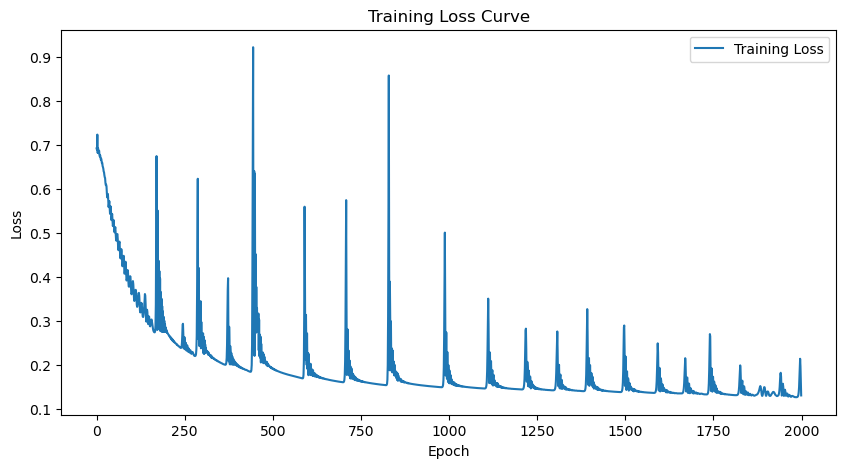

Final Model Accuracy: 82.37%
Final Model F1-score: 0.8354


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_0_layer.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.90      0.74      0.81       194
non_infringement       0.77      0.91      0.84       186

        accuracy                           0.82       380
       macro avg       0.83      0.83      0.82       380
    weighted avg       0.84      0.82      0.82       380



/tmp/ipykernel_55564/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
